In [1]:
import numpy as np
import pandas as pd
from spec_id import Median_w_Error,Gen_spec
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../chidat/BF_fullfit.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

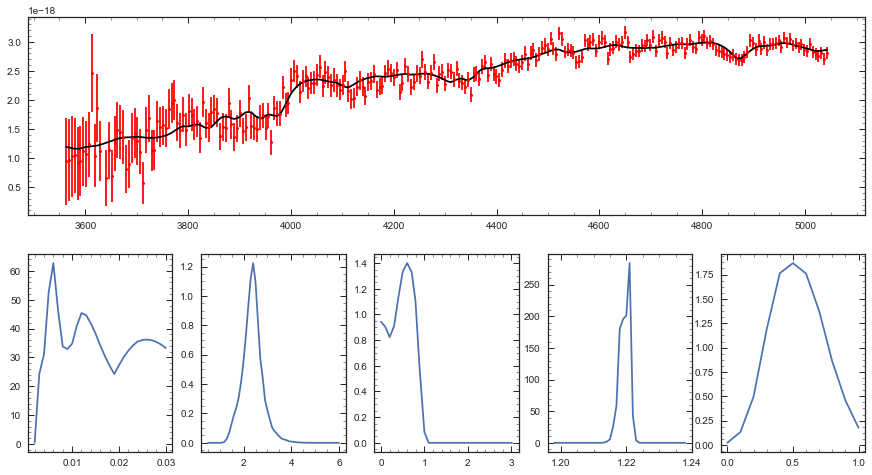

In [4]:
gs = GridSpec(2,5)
Z,PZ = np.load('../chidat/{0}_full_fit_Z_pos.npy'.format(galDB.gids[0]))
t,Pt = np.load('../chidat/{0}_full_fit_t_pos.npy'.format(galDB.gids[0]))
ult,Ptau = np.load('../chidat/{0}_full_fit_tau_pos.npy'.format(galDB.gids[0]))
z,Pz = np.load('../chidat/{0}_full_fit_rs_pos.npy'.format(galDB.gids[0]))
d,Pd = np.load('../chidat/{0}_full_fit_d_pos.npy'.format(galDB.gids[0]))

medZ,mler,mher = Median_w_Error(PZ,Z)
medt,mler,mher = Median_w_Error(Pt,t)
medtau,mler,mher = Median_w_Error(Ptau,ult)
medz,mler,mher = Median_w_Error(Pz,z)
medd,mler,mher = Median_w_Error(Pd,d)

sp = Gen_spec(galDB.gids[0],medz,maxwv=11200)
sp.Sim_spec(medZ,medt,0,z[Pz == max(Pz)][0],medd)
sp.Fit_lwa(medZ,medt,z[Pz == max(Pz)][0],medd,metal,age,tau)

plt.figure(figsize=[15,8])
plt.subplot(gs[0,:])
plt.errorbar(sp.gal_wv_rf,sp.gal_fl, sp.gal_er,linestyle='None', marker='o', markersize=3, color='r')
plt.plot(sp.gal_wv_rf,sp.fl,'k')

plt.subplot(gs[1,0])
plt.plot(Z,PZ)
plt.subplot(gs[1,1])
plt.plot(t,Pt)
plt.subplot(gs[1,2])
plt.plot(ult,Ptau)
plt.subplot(gs[1,3])
plt.plot(z,Pz)
plt.subplot(gs[1,4])
plt.plot(d,Pd)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

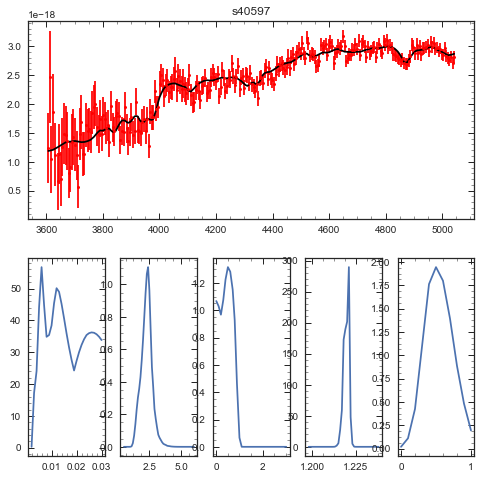

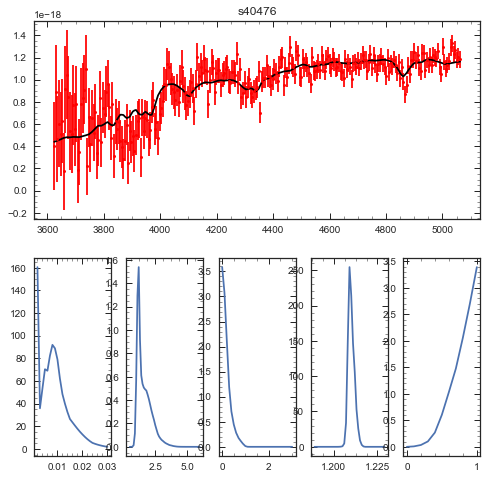

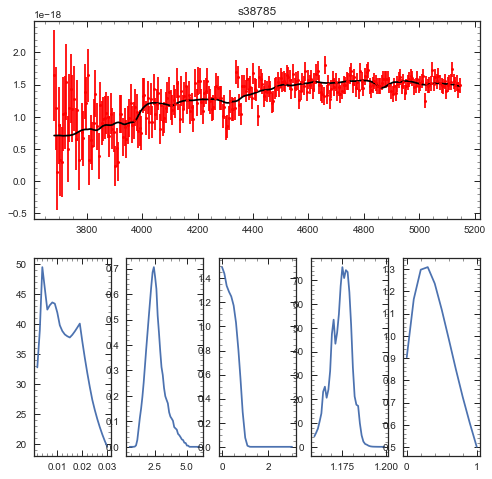

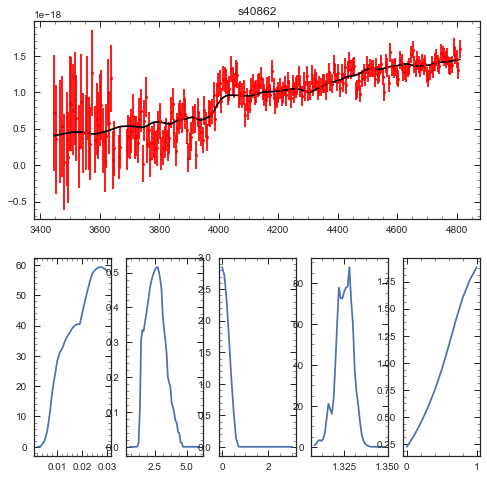

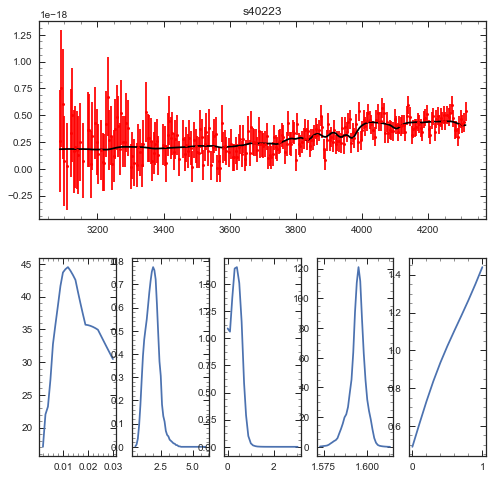

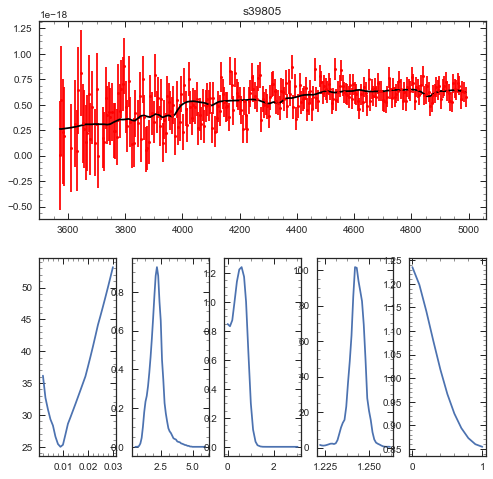

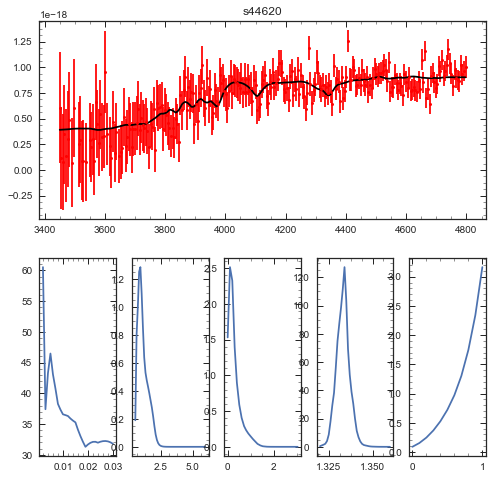

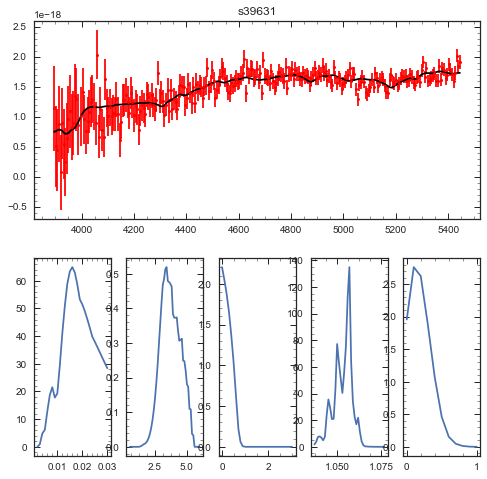

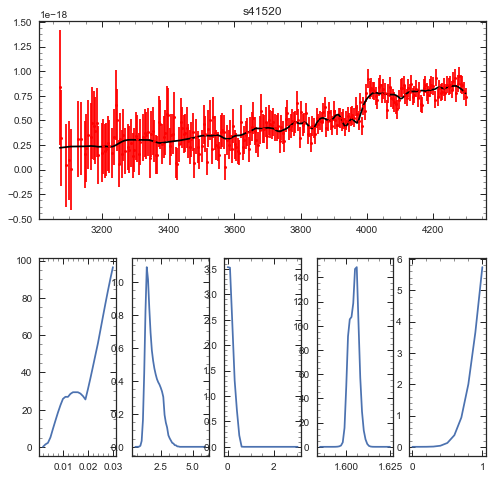

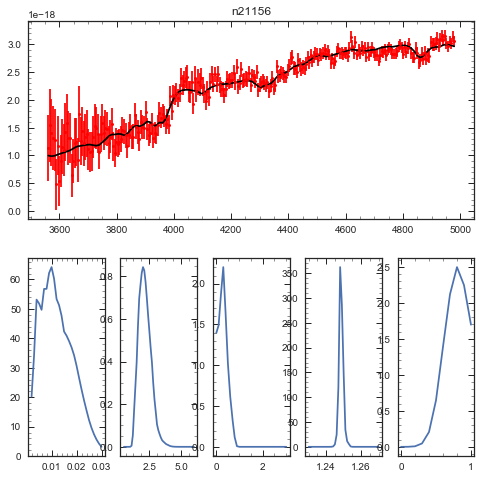

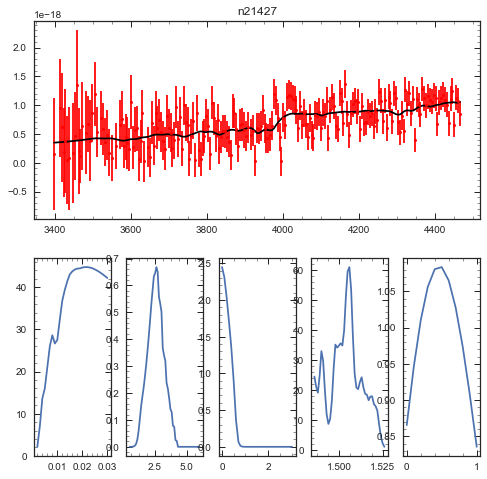

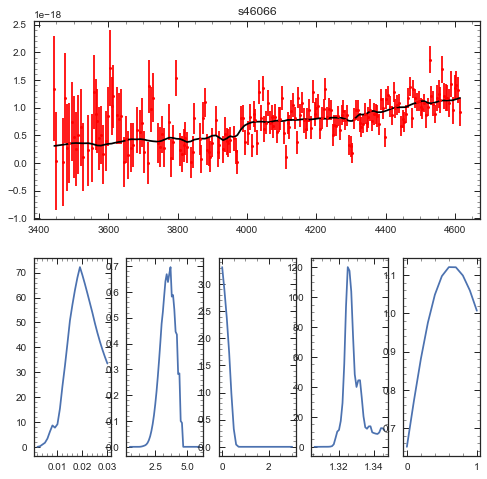

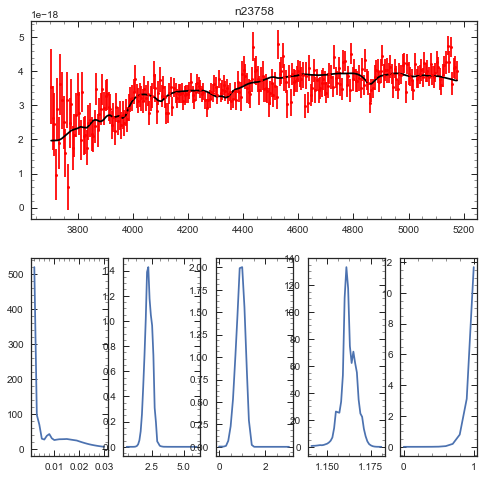

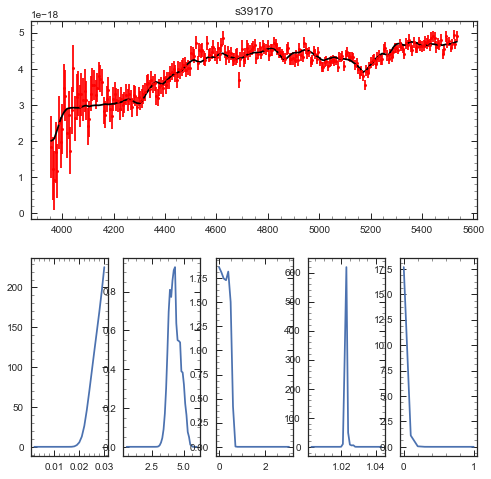

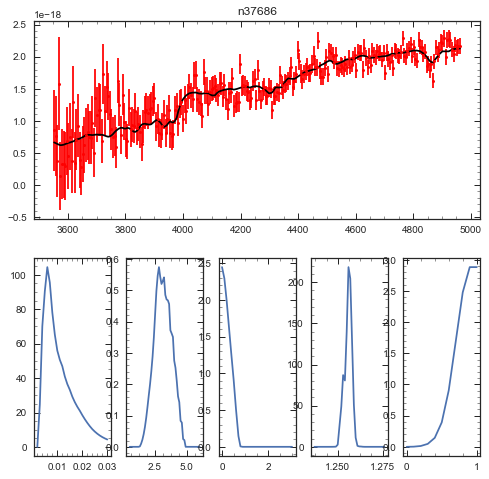

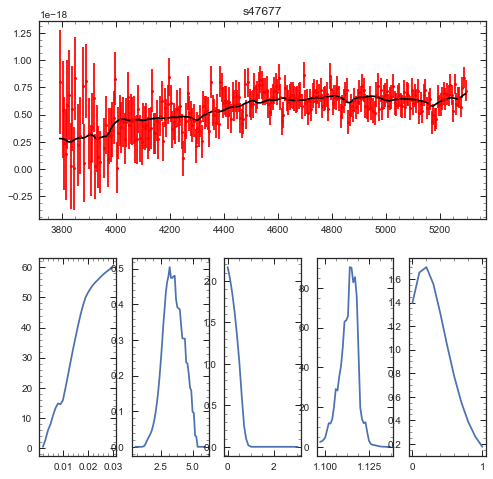

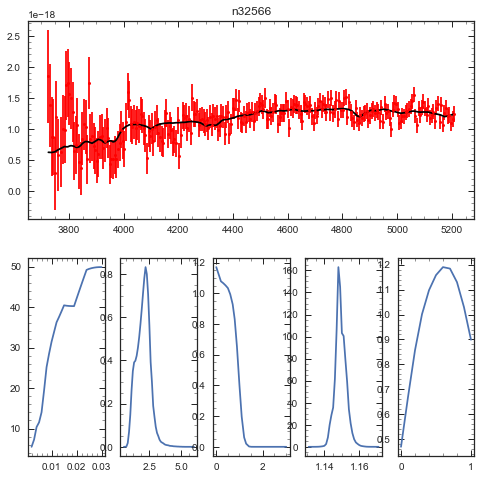

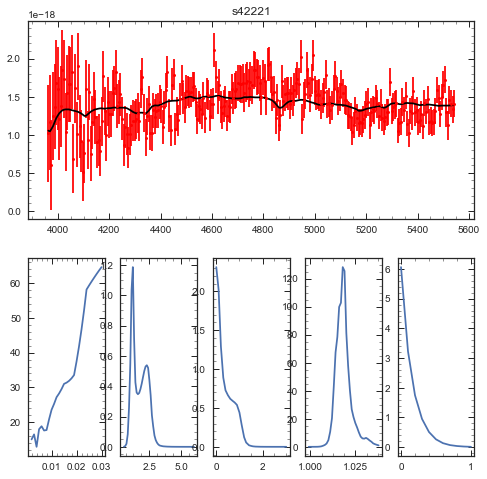

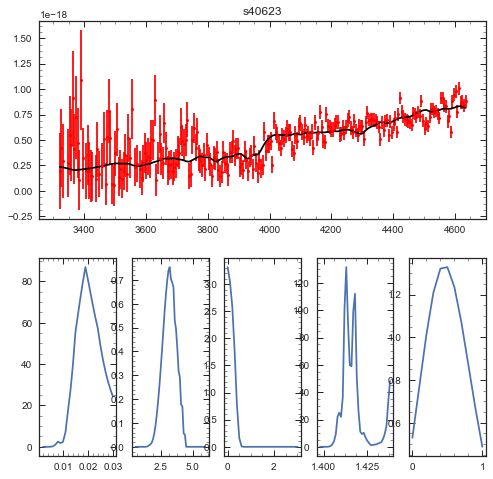

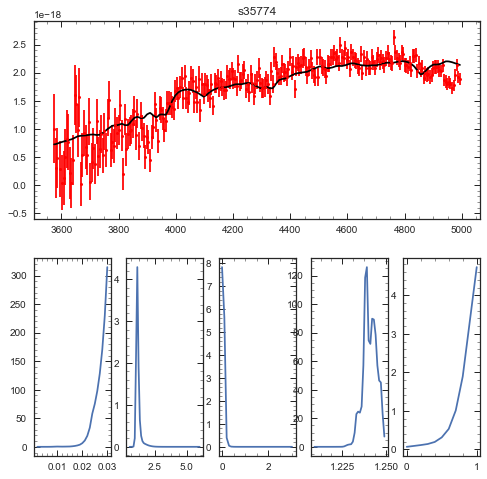

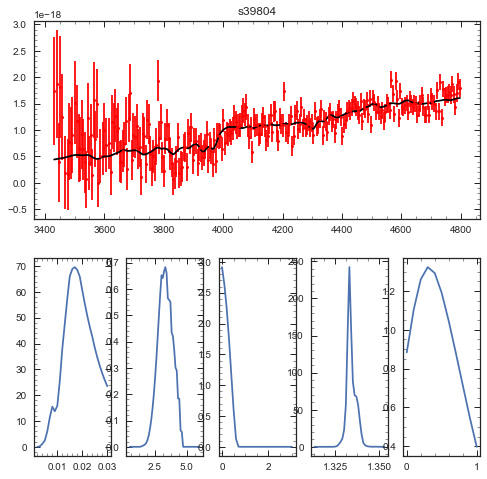

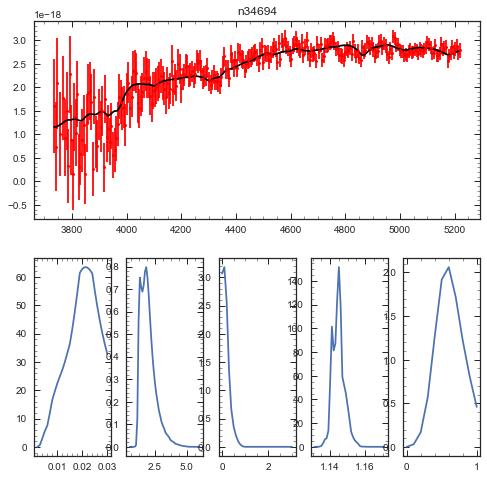

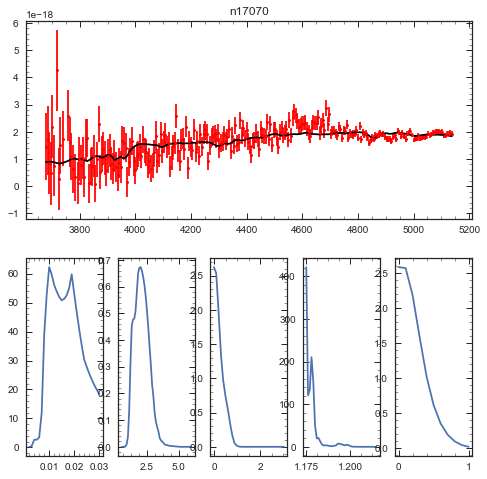

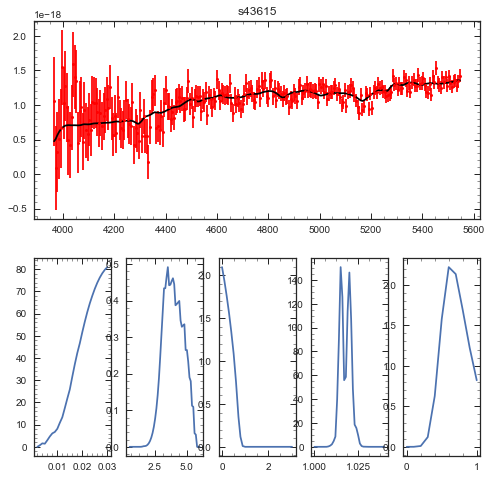

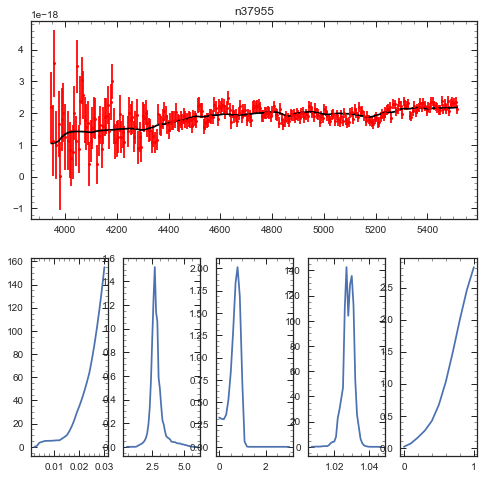

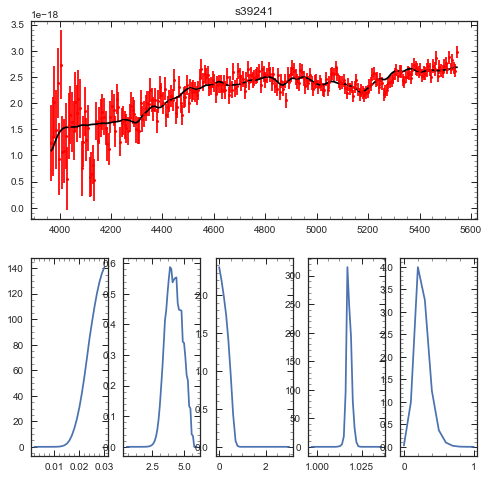

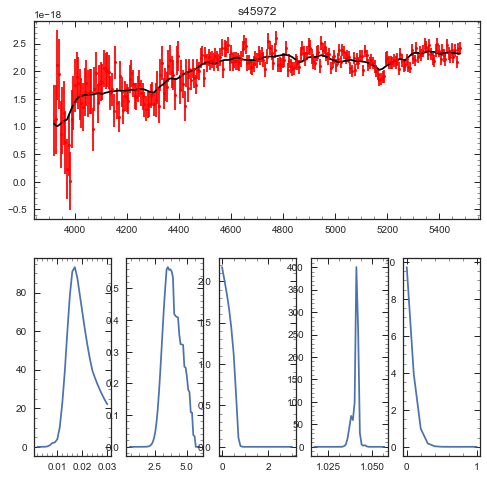

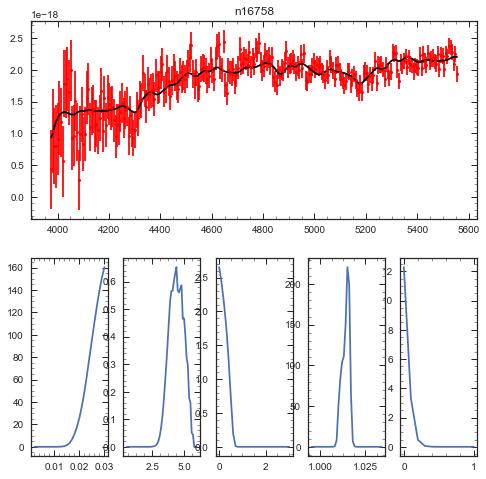

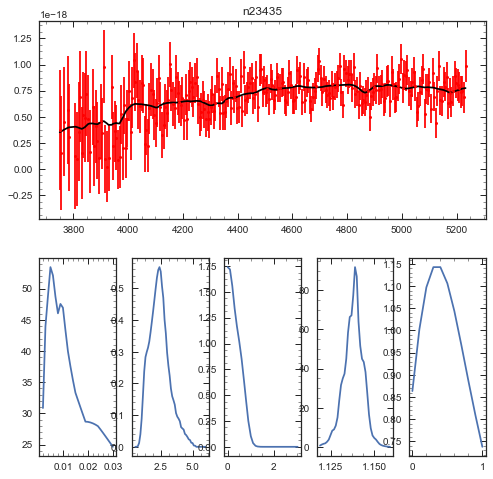

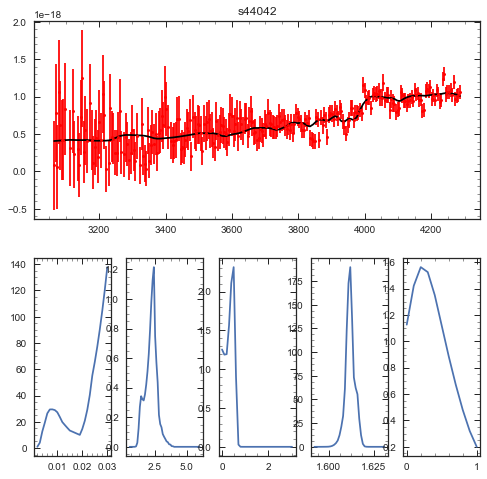

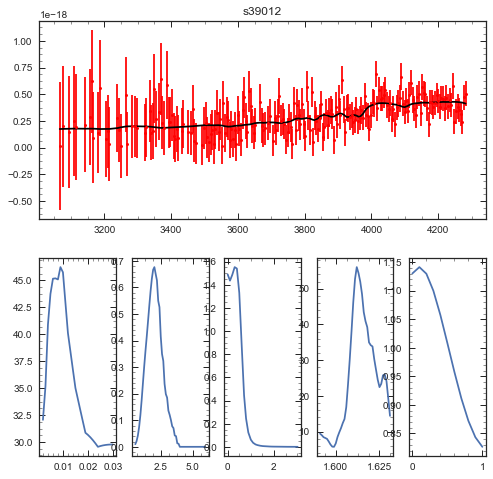

In [8]:
gs = GridSpec(2,5)
WV,TEF = np.load('../data/template_error_function.npy')
for i in galDB.index:
    Z,PZ = np.load('../chidat/{0}_full_fit_Z_pos.npy'.format(galDB.gids[i]))
    t,Pt = np.load('../chidat/{0}_full_fit_t_pos.npy'.format(galDB.gids[i]))
    ult,Ptau = np.load('../chidat/{0}_full_fit_tau_pos.npy'.format(galDB.gids[i]))
    z,Pz = np.load('../chidat/{0}_full_fit_rs_pos.npy'.format(galDB.gids[i]))
    d,Pd = np.load('../chidat/{0}_full_fit_d_pos.npy'.format(galDB.gids[i]))
    
    medZ,mler,mher = Median_w_Error(PZ,Z)
    medt,mler,mher = Median_w_Error(Pt,t)
    medtau,mler,mher = Median_w_Error(Ptau,ult)
    medz,mler,mher = Median_w_Error(Pz,z)
    medd,mler,mher = Median_w_Error(Pd,d)

    sp = Gen_spec(galDB.gids[i],medz,minwv=8000,maxwv=11200)
    sp.Fit_lwa(medZ,medt,z[Pz == max(Pz)][0],medd,metal,age,tau)

    iTEF = interp1d(WV,TEF)(sp.gal_wv_rf)
    
    plt.figure(figsize=[8,8])
    plt.subplot(gs[0,:])
    plt.errorbar(sp.gal_wv_rf,sp.gal_fl, np.sqrt(sp.gal_er**2 + (iTEF*sp.gal_fl)**2),
                 linestyle='None', marker='o', markersize=3, color='r')
    plt.plot(sp.gal_wv_rf,sp.fl,'k')
    plt.title(galDB.gids[i])
    
    plt.subplot(gs[1,0])
    plt.plot(Z,PZ)
    plt.subplot(gs[1,1])
    plt.plot(t,Pt)
    plt.subplot(gs[1,2])
    plt.plot(ult,Ptau)
    plt.subplot(gs[1,3])
    plt.plot(z,Pz)
    plt.subplot(gs[1,4])
    plt.plot(d,Pd)

In [9]:
galDB

,bfZ,bfd,bft,bftau,bfz,gids
0,0.025,0.6,4.5,8.90,1.221,s40597
1,0.009,1.0,1.1,0.00,1.209,s40476
2,0.019,0.2,1.9,0.00,1.175,s38785
3,0.021,1.0,1.4,0.00,1.328,s40862
4,0.025,1.0,5.3,9.04,1.595,s40223
5,0.030,0.0,1.3,0.00,1.242,s39805
6,0.030,0.8,0.8,8.00,1.334,s44620
7,0.008,0.2,6.0,0.00,1.057,s39631
8,0.030,0.9,1.9,8.30,1.605,s41520
9,0.019,0.8,2.4,8.48,1.248,n21156
